<h1 align = center> <strong>Stroke Prediction</strong> </h1>
<h3 align = center> Team members : Shrutayu Aggarwal (B20CS096), Priyanshu Jain (B20CS044), Pratul Singh (B20CS095)

##**Useful Library Import**

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import torch 
import os
import tensorflow as tf
from tensorflow import keras
import torch.nn as nn
from torch.autograd import Variable
from sklearn.utils import shuffle
from torchsummary import summary
from sklearn.model_selection import GridSearchCV , train_test_split , StratifiedShuffleSplit , StratifiedKFold, cross_val_score , RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder , StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score,ConfusionMatrixDisplay,precision_score,recall_score,f1_score,classification_report,roc_curve,plot_roc_curve,auc,precision_recall_curve,plot_precision_recall_curve,average_precision_score

##**Useful models import**

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier 
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb

##**Reading Dataset**

In [3]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQBkbBa7swoXVRNgWzDQDhAFZDp_MvcAPusdQkE7y_FcFVx0SjCvXY8uIbzmsbX6hvOWXL1AjLjzjDq/pub?output=csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


##**Preprocessing of dataset**

In [4]:
df = df.drop(columns=['id'], axis = 1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Checking for missing values

In [5]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Erasing missing values

In [6]:
df = df.dropna()
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Checking the type of each columns

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4909 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4909 non-null   object 
 1   age                4909 non-null   float64
 2   hypertension       4909 non-null   int64  
 3   heart_disease      4909 non-null   int64  
 4   ever_married       4909 non-null   object 
 5   work_type          4909 non-null   object 
 6   Residence_type     4909 non-null   object 
 7   avg_glucose_level  4909 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     4909 non-null   object 
 10  stroke             4909 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 460.2+ KB


Looking for the categorical columns which needs to be LabelEncoded

In [8]:
categorical_columns = []
for column in df.columns:
  if df[column].dtypes == object:
    categorical_columns.append(column)
categorical_columns

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

Let us keep initially the continuous value columns and discrete value columns in numerical category.

In [9]:
numerical_columns = []
for column in df.columns:
  if column not in categorical_columns and column!='stroke':
    numerical_columns.append(column)
numerical_columns

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

#**Exploratory Data Analysis**

Checking is there exist any imbalance in the dataset or not

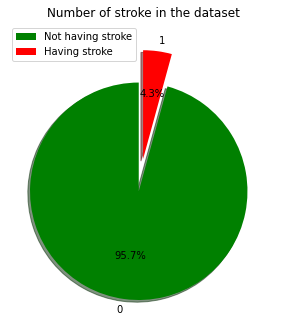

In [10]:
labels = df['stroke'].value_counts(sort = True).index
sizes = df['stroke'].value_counts(sort = True)
colors = ["green","red"]
expd = (0.3,0) 
plt.figure(figsize=(5,5))
plt.pie(sizes,explode=expd,labels=labels,colors=colors,autopct='%1.1f%%',shadow=True,startangle=90)
plt.title('Number of stroke in the dataset')
plt.legend(["Not having stroke" , "Having stroke"])
plt.show()

From the above pie chart it is clearly visible that there is high imbalance in the dataset.

##Which metric to use?

    
*  Now, since the dataset is imbalanced and it is the binary classification problem, the best metric for evalution would be *Area under the ROC curve (AUC)*.
We can also use precesion and recall, but AUC combines both of these metrices.



*   Since it is a binary classification problem and from the above target distribution we can see that there are skewed targets hence we need to use *StratifiedKFold to split the data*



##Categorical Columns  --  [ ' gender ' , ' ever_married ' , ' work_type ' , ' Residence_type ' , ' smoking_status ' ]






For all the features lets see the variation of numbers against the target variable 'stroke'

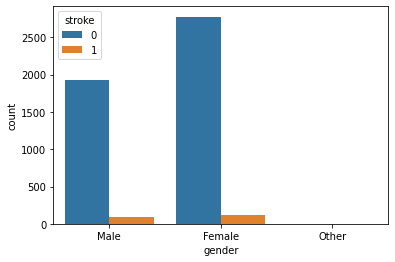

In [11]:
sns.countplot(x='gender', hue='stroke', data=df)

From the above graph, it seems that exist some samples for gender = 'Other' , Lets see how much the count is:

In [12]:
df['gender'].value_counts()

Female    2897
Male      2011
Other        1
Name: gender, dtype: int64

Since only a single value exist for gender = 'Other' we can easily drop this value

In [13]:
df = df.drop(df[df['gender'] == 'Other'].index,axis = 0)

In [14]:
df['gender'].value_counts()

Female    2897
Male      2011
Name: gender, dtype: int64

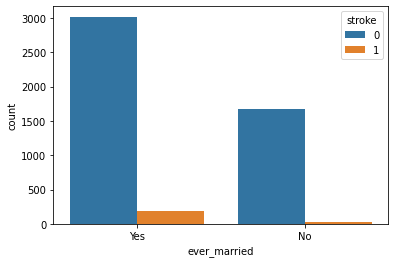

In [15]:
sns.countplot(x='ever_married', hue='stroke', data=df)

Now it can be seen that the chance of getting stroke if married is larger than not married, so seems to be a useful feature in classification

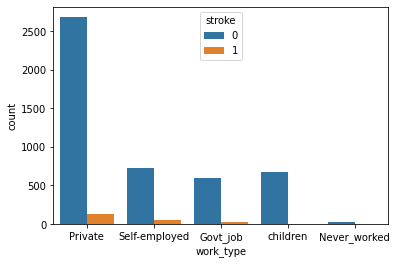

In [16]:
sns.countplot(x='work_type', hue='stroke', data=df)

The people who work are likely to get stroke 

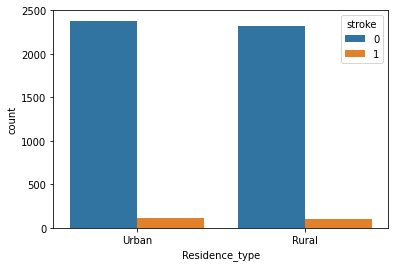

In [17]:
sns.countplot(x='Residence_type', hue='stroke', data=df)

Since the number for both the classes seems to be approximately equal, it doesnot sounds to be an important featture

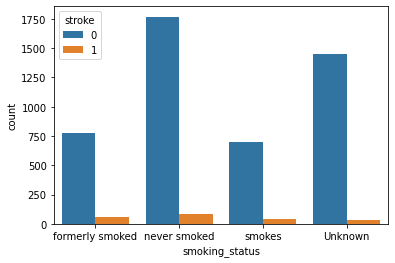

In [18]:
sns.countplot(x='smoking_status', hue='stroke', data=df)

Wonder!!!
Smoking should be a important feature while classifying for the stroke but alas we found that only a very little difference is present among all, lets see the actual figures.

In [19]:
df.groupby(['smoking_status','stroke'])['stroke'].count()

smoking_status   stroke
Unknown          0         1454
                 1           29
formerly smoked  0          779
                 1           57
never smoked     0         1768
                 1           84
smokes           0          698
                 1           39
Name: stroke, dtype: int64

Lets keep this feature on the accout that it is more often to have stroke if the person smokes as (formerly smoke+ smokes > never smoked)

##Discrete Columns -- [ ' heart_disease' , ' hypertension ' ]




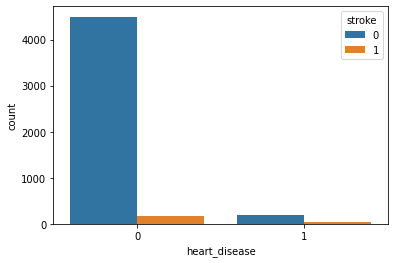

In [20]:
sns.countplot(x='heart_disease', hue='stroke', data=df)

It seems like people having Heart Disease are more likely to have stroke

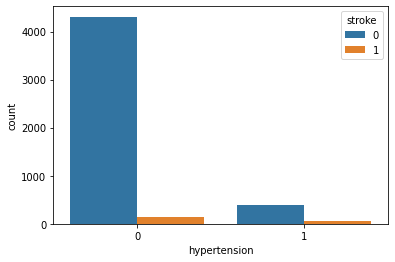

In [21]:
sns.countplot(x='hypertension', hue='stroke', data=df)

Let's see the original numbers

In [22]:
df['hypertension'].value_counts()

0    4457
1     451
Name: hypertension, dtype: int64

In [23]:
df.groupby(['hypertension','stroke'])['stroke'].count()

hypertension  stroke
0             0         4308
              1          149
1             0          391
              1           60
Name: stroke, dtype: int64

It seems like people not having any hypertension are likely to get stroke

Lets check the correctness of above statement with heart diesease as it is a fact that a person with hypertension is likely to stroke.

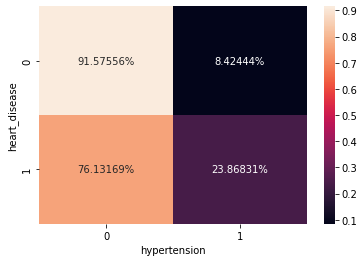

In [24]:
cross_tab=pd.crosstab(df['heart_disease'],df['hypertension'],normalize='index')
sns.heatmap(cross_tab,annot=True,fmt="1.5%")
plt.show()

So from above heatmap, we can conclude that a person with *not* having hypertension is likely to have stroke irrespective of whether he/she has heart_disease or not.

##Continuous Columns -- [ ' age ' , ' avg_glucose_level ' , ' bmi ' ]



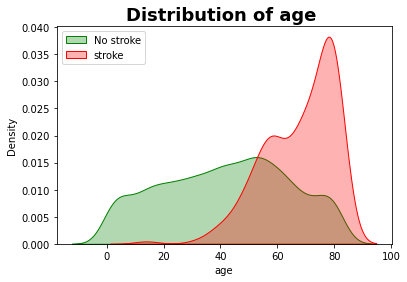

In [25]:
sns.kdeplot(data=df[df['stroke']==0],x='age',color='green', shade=True,alpha=0.3)
sns.kdeplot(data=df[df['stroke']==1],x='age',color='red', shade=True,alpha=0.3)
plt.title("Distribution of age ",fontdict={'fontweight': 'bold', 'size':18})
plt.legend(['No stroke' , 'stroke'],loc = 'upper left')

From the above distribution, people with more age are likely to have stroke than the people with less age.

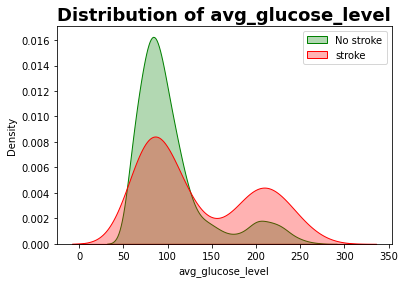

In [26]:
sns.kdeplot(data=df[df['stroke']==0],x='avg_glucose_level',color='green', shade=True,alpha=0.3)
sns.kdeplot(data=df[df['stroke']==1],x='avg_glucose_level',color='red', shade=True,alpha=0.3)
plt.title("Distribution of avg_glucose_level",fontdict={'fontweight': 'bold', 'size':18})
plt.legend(['No stroke' , 'stroke'],loc = 'upper right')

There is *very little relation between avg_glucose_level and stroke*. Similar glucose level has stroke as well as not stroke. If a person has avg_glucose_level > 150, he/she has very likely to have stroke.

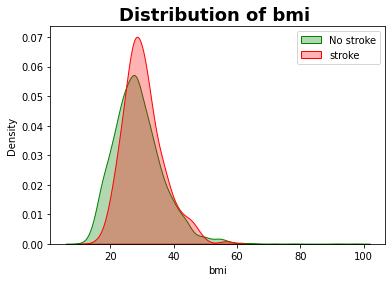

In [27]:
sns.kdeplot(data=df[df['stroke']==0],x='bmi',color='green', shade=True,alpha=0.3)
sns.kdeplot(data=df[df['stroke']==1],x='bmi',color='red', shade=True,alpha=0.3)
plt.title("Distribution of bmi ",fontdict={'fontweight': 'bold', 'size':18})
plt.legend(['No stroke' , 'stroke'],loc = 'upper right')

There is *no relation between bmi and stroke*. Similar bmi has stroke as well as not stroke.

#**Feature Engineering**

## Encoding Categorical columns

In [28]:
print(categorical_columns)

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [29]:
for column in categorical_columns:
  print(column + " has "  + str(df[column].unique()) + " unique values")

gender has ['Male' 'Female'] unique values
ever_married has ['Yes' 'No'] unique values
work_type has ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked'] unique values
Residence_type has ['Urban' 'Rural'] unique values
smoking_status has ['formerly smoked' 'never smoked' 'smokes' 'Unknown'] unique values


In [30]:
encode = {"gender" : { "Male" : 1 , "Female" : 0} , "ever_married" : {"Yes" : 1 , "No" : 0} , "work_type" : {"Private" : 0 , "Self-employed" : 1 , 
                "Govt_job" : 2 , "children" : 3, "Never_worked" : 4} , "Residence_type" : {"Urban" : 1 , "Rural" : 0} , "smoking_status" : {"formerly smoked" : 0
                , "never smoked" : 1, "smokes" : 2 , "Unknown" : 3}}
df = df.replace(encode)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,0,1,228.69,36.6,0,1
2,1,80.0,0,1,1,0,0,105.92,32.5,1,1
3,0,49.0,0,0,1,0,1,171.23,34.4,2,1
4,0,79.0,1,0,1,1,0,174.12,24.0,1,1
5,1,81.0,0,0,1,0,1,186.21,29.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,0,13.0,0,0,0,3,0,103.08,18.6,3,0
5106,0,81.0,0,0,1,1,1,125.20,40.0,1,0
5107,0,35.0,0,0,1,1,0,82.99,30.6,1,0
5108,1,51.0,0,0,1,0,0,166.29,25.6,0,0


## Dealing with continuous columns

In [31]:
continuous_columns = ['age','avg_glucose_level','bmi']
df[continuous_columns].describe()

,age,avg_glucose_level,bmi
count,4908.000000,4908.000000,4908.00000
mean,42.868810,105.297402,28.89456
std,22.556128,44.425550,7.85432
min,0.080000,55.120000,10.30000
25%,25.000000,77.067500,23.50000
50%,44.000000,91.680000,28.10000
75%,60.000000,113.495000,33.10000
max,82.000000,271.740000,97.60000


As we can see that continuous columns are measured in differnt scales so we need to standarize them by doing standardization (Standard scaler).

In [32]:
scaler = StandardScaler()
df[continuous_columns] = scaler.fit_transform(df[continuous_columns])
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,1.069938,0,1,1,0,1,2.777797,0.981145,0,1
2,1,1.646336,0,1,1,0,0,0.014016,0.459086,1,1
3,0,0.271847,0,0,1,0,1,1.484266,0.701016,2,1
4,0,1.601998,1,0,1,1,0,1.549325,-0.623231,1,1
5,1,1.690675,0,0,1,0,1,1.821493,0.013426,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,0,-1.324334,0,0,0,3,0,-0.049918,-1.310821,3,0
5106,0,1.690675,0,0,1,1,1,0.448045,1.414072,1,0
5107,0,-0.348890,0,0,1,1,0,-0.502181,0.217156,1,0
5108,1,0.360524,0,0,1,0,0,1.373057,-0.419501,0,0


##**Splitting data in training(70%), validation(10%) and testing(20%) using stratified split method**

In [33]:
df.reset_index(inplace = True)
df.drop("index",axis = 1, inplace = True)

In [34]:
data = df.copy()
data = data.drop(columns = ['bmi'],axis=1)
X = data.drop(columns=['stroke'],axis=1)
Y = data[['stroke']]

In [35]:
def split(X,Y):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3,random_state = 42)
  for train_index, test_index in sss.split(X, Y):
    x_train = X.loc[train_index]
    y_train = Y.loc[train_index]
    test_x = X.loc[test_index]
    test_y = Y.loc[test_index]

  x_train.reset_index(inplace = True)
  x_train.drop("index",axis = 1, inplace = True)

  y_train.reset_index(inplace = True)
  y_train.drop("index",axis = 1, inplace = True)

  test_x.reset_index(inplace = True)
  test_x.drop("index",axis = 1, inplace = True)

  test_y.reset_index(inplace = True)
  test_y.drop("index",axis = 1, inplace = True)

  sss = StratifiedShuffleSplit(n_splits=1, test_size= 1/3, random_state=42)
  for test_index, val_index in sss.split(test_x, test_y):
    x_test = test_x.loc[test_index]
    y_test = test_y.loc[test_index]
    x_val =   test_x.loc[val_index]
    y_val =   test_y.loc[val_index]


  x_test.reset_index(inplace = True)
  x_test.drop("index",axis = 1, inplace = True)

  y_test.reset_index(inplace = True)
  y_test.drop("index",axis = 1, inplace = True)

  x_val.reset_index(inplace = True)
  x_val.drop("index",axis = 1, inplace = True)

  y_val.reset_index(inplace = True)
  y_val.drop("index",axis = 1, inplace = True)

  return x_train, y_train , x_val, y_val , x_test , y_test

In [36]:
x_train, y_train , x_val, y_val , x_test , y_test = split(X,Y)

#**Training multiple models without taking care of imbalanced dataset**

In [37]:
models = [LogisticRegression() , KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), BernoulliNB() , GradientBoostingClassifier()]
model_names = ['LogisticRegression','KNeighborsClassifier','DecisionTreeClassifier','RandomForestClassifier','BernoulliNB','GradientBoostingClassifier','XGBClassifier','LightGBM']
Precision = []
Recall = []
ROC = []
F1 = []

In [38]:
def training_summary(x_train, y_train, x_val, y_val, model_name , model):
  model.fit(x_train, y_train)
  prediction = model.predict(x_val)
  precision = precision_score(y_val, prediction)*100
  recall = recall_score(y_val, prediction)*100
  roc = roc_auc_score(y_val,prediction)*100
  f1 = f1_score(y_val,prediction)*100
  Precision.append(precision)
  Recall.append(recall)
  ROC.append(roc)
  F1.append(f1)
  # return precision, recall , roc, f1

In [39]:
def modelling():
  training_summary(x_train,y_train, x_val, y_val, 'LogisticRegression',LogisticRegression())
  training_summary(x_train,y_train, x_val, y_val, 'KNeighborsClassifier',KNeighborsClassifier(n_neighbors=1,algorithm='kd_tree',weights='uniform'))
  training_summary(x_train,y_train, x_val, y_val, 'DecisionTreeClassifier',DecisionTreeClassifier())
  training_summary(x_train,y_train, x_val, y_val, 'RandomForestClassifier',RandomForestClassifier(n_estimators=50,n_jobs=-1))
  training_summary(x_train,y_train, x_val, y_val, 'BernoulliNB',BernoulliNB())
  training_summary(x_train,y_train, x_val, y_val, 'GradientBoostingClassifier',GradientBoostingClassifier(learning_rate=0.1,loss='exponential',max_depth=70,
                          max_features=2,n_estimators=300))
  training_summary(x_train,y_train, x_val, y_val, 'XGBClassifier',xgb.XGBClassifier())
  training_summary(x_train,y_train, x_val, y_val, 'LGBMClassifier',lgb.LGBMClassifier())

In [40]:
modelling()

In [41]:
model_names = ['LogisticRegression','KNeighborsClassifier','DecisionTreeClassifier','RandomForestClassifier','BernoulliNB','GradientBoostingClassifier','XGBClassifier','LightGBM']
score = pd.DataFrame({'Model': model_names, 'Precision': Precision, 'Recall': Recall, 'ROC_AUC_Score' : ROC,'F1_score' : F1})
score.style.background_gradient(high=1,axis=0)

,Model,Precision,Recall,ROC_AUC_Score,F1_score
0,LogisticRegression,0.000000,0.000000,49.893617,0.000000
1,KNeighborsClassifier,15.789474,14.285714,55.440729,15.000000
2,DecisionTreeClassifier,16.000000,19.047619,57.289767,17.391304
3,RandomForestClassifier,50.000000,4.761905,52.274569,8.695652
4,BernoulliNB,16.666667,9.523810,53.698075,12.121212
5,GradientBoostingClassifier,12.500000,4.761905,51.636272,6.896552
6,XGBClassifier,25.000000,4.761905,52.061803,8.000000
7,LightGBM,50.000000,9.523810,54.549139,16.000000


We can clearly see that how poor our models works as the dataset was highly imbalanced.

Let's firstly work on making the dataset balanced

#**Synthetic Minority Oversampling Technique**

<p align = center>This problem has imbalanced classification i.e., there are too few examples of the minority class for a model to effectively learn the decision boundary.One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model</p>
<img src="https://miro.medium.com/max/1400/1*yRumRhn89acByodBz0H7oA.png">
<p >Synthetic Sample generation using SMOTE</p>

#**Defining object of SMOTE() and again using stratified split**

In [42]:
smote = SMOTE()
X_smote , Y_smote = smote.fit_resample(X,Y)
x_train, y_train , x_val, y_val , x_test , y_test = split(X_smote,Y_smote)

In [43]:
data_smote = pd.concat([X_smote, Y_smote],axis=1)

## Visualising our SMOTE dataset

Text(0.5, 1.0, 'SMOTE')

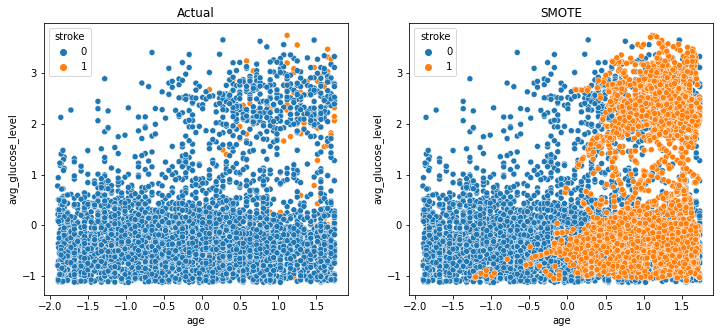

In [44]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(data=data,x='age',y='avg_glucose_level',hue='stroke',ax=ax[0])\
.set_title("Actual")
sns.scatterplot(data=data_smote,x='age',y='avg_glucose_level',hue='stroke',ax=ax[1])\
.set_title("SMOTE")

In [45]:
Precision = []
Recall = []
ROC = []
F1 = []

##**Modelling via SMOTE**

In [46]:
modelling()

**Scores after applying SMOTE**

In [47]:
model_names = ['LogisticRegression','KNeighborsClassifier','DecisionTreeClassifier','RandomForestClassifier','BernoulliNB','GradientBoostingClassifier','XGBClassifier','LightGBM']
score = pd.DataFrame({'Model': model_names, 'Precision': Precision, 'Recall': Recall,'ROC_AUC_Score' : ROC, 'F1_Score' : F1})
score.style.background_gradient(high=1,axis=0)

,Model,Precision,Recall,ROC_AUC_Score,F1_Score
0,LogisticRegression,77.432712,79.574468,78.191489,78.488982
1,KNeighborsClassifier,87.598425,94.680851,90.638298,91.002045
2,DecisionTreeClassifier,92.016807,93.191489,92.553191,92.600423
3,RandomForestClassifier,89.570552,93.191489,91.170213,91.345151
4,BernoulliNB,67.169179,85.319149,71.808511,75.164011
5,GradientBoostingClassifier,91.060291,93.191489,92.021277,92.113565
6,XGBClassifier,81.091618,88.510638,83.936170,84.638861
7,LightGBM,95.833333,92.978723,94.468085,94.384449


From the above results we can see that LogisticRegression , BernoulliNB didn't worked well as we can easily see them using ROC_AUC_score

Visualising the ROC_AUC_SCORE and see which is greatest and most accurate to use.

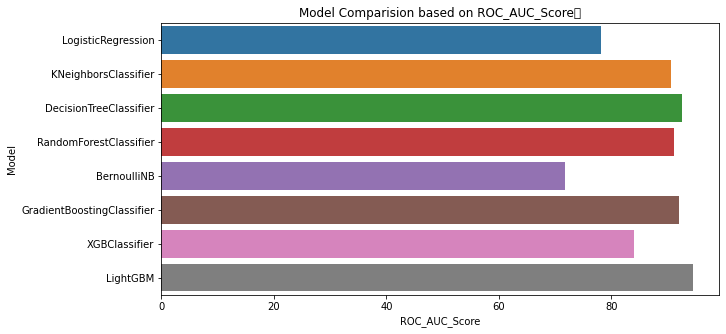

In [48]:
plt.figure(figsize = (10 , 5))
sns.barplot(y = "Model" , x = "ROC_AUC_Score" , data = score)
plt.title("Model Comparision based on ROC_AUC_Score	");


Visualising the F1 score and see which is greatest and most accurate to use.

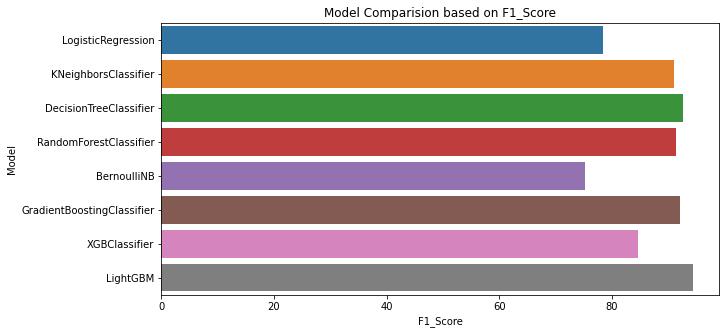

In [49]:
plt.figure(figsize = (10 , 5))
sns.barplot(y = "Model" , x = "F1_Score" , data = score)
plt.title("Model Comparision based on F1_Score");

Combining all the metrics used and looking for the correct models

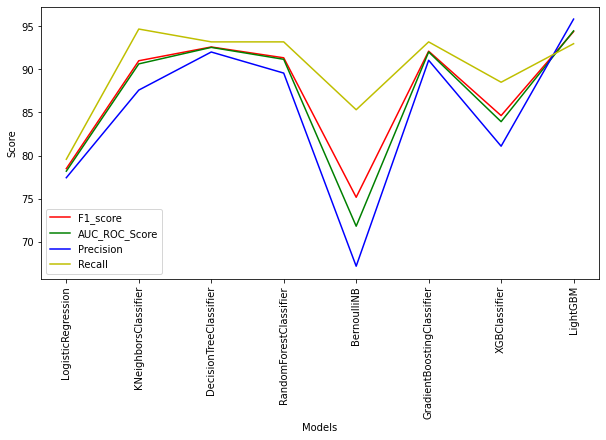

In [50]:
plt.figure(figsize = (10 , 5))
plt.plot(model_names, F1, color = 'r', label = 'F1_score')
plt.plot(model_names, ROC, color = 'g', label = 'AUC_ROC_Score')
plt.plot(model_names, Precision, color = 'b', label = 'Precision')
plt.plot(model_names, Recall, color = 'y', label = 'Recall')
plt.xticks(rotation=90)
plt.xlabel("Models")
plt.ylabel("Score")
plt.legend()

Since If Stroke is not predicted correctly it may lead to severe damages to body and even death and it should be predicted accuractely, which implies if a person has a Stroke then it should be predicted that he has stroke rather than predicting not having stroke which implies False negative should be extremely small which means our model should be sensitive or we should take the model having high Recall Score.

From above clarification we can judge from the above graph that respective models works very good.


*   KNN
*   RFC
*   Gradient Boosting Classifier
*   XGBClassifier
*   LightGBMClassifier
*   DTC











Now's Let's Tune each one of these models to get the best hyperparameters so that we can obtain maximum AUC_ROC_score

In [51]:
tuned_validation_roc_auc_scores = []

##Tuning XGB as we have got less ROC_AUC score for it

In [52]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ,9],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [53]:
xgb_ = XGBClassifier()
xgb_tuning = RandomizedSearchCV(xgb_, param_distributions = params, n_iter = 8, scoring = 'roc_auc', n_jobs = 1, cv = 5, verbose = 3)
xgb_tuning.fit(x_train , y_train)
xgb_tuning.best_estimator_
xgb_tuning.best_params_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.2, max_depth=8, min_child_weight=5;, score=0.975 total time=   0.4s
[CV 2/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.2, max_depth=8, min_child_weight=5;, score=0.978 total time=   0.5s
[CV 3/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.2, max_depth=8, min_child_weight=5;, score=0.975 total time=   0.5s
[CV 4/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.2, max_depth=8, min_child_weight=5;, score=0.982 total time=   0.5s
[CV 5/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.2, max_depth=8, min_child_weight=5;, score=0.977 total time=   0.4s
[CV 1/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=15, min_child_weight=1;, score=0.988 total time=   1.0s
[CV 2/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=15, min_child_weight=1;, score=0.991 total time=   1.2s
[CV 3/5] END colsample_bytre

{'colsample_bytree': 0.5,
 'gamma': 0.3,
 'learning_rate': 0.3,
 'max_depth': 15,
 'min_child_weight': 1}

In [54]:
tuned_validation_roc_auc_scores.append(max(0,roc_auc_score(y_val, xgb_tuning.predict(x_val))))

In [55]:
cv_score_xgb = max(0,roc_auc_score(y_val, xgb_tuning.predict(x_val)))

In [56]:
tuned_validation_roc_auc_scores

[0.9617021276595745]

##Tuning LGBM Classifier

In [57]:
lgb_ = lgb.LGBMClassifier()
lgb_tuning = RandomizedSearchCV(lgb_, param_distributions = params, n_iter = 8, scoring = 'roc_auc', n_jobs = 1, cv = 5, verbose = 3)
lgb_tuning.fit(x_train , y_train)
lgb_tuning.best_estimator_
lgb_tuning.best_params_
max(0,roc_auc_score(y_val, lgb_tuning.predict(x_val)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=7;, score=0.982 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=7;, score=0.983 total time=   0.1s
[CV 3/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=7;, score=0.981 total time=   0.1s
[CV 4/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=7;, score=0.984 total time=   0.1s
[CV 5/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=7;, score=0.980 total time=   0.1s
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=5;, score=0.975 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.2, max_depth=6, min_child_weight=5;, score=0.976 total time=   0.1s
[CV 3/5] END colsample_by

0.95

In [58]:
lgb_tuning.best_params_

{'colsample_bytree': 0.5,
 'gamma': 0.0,
 'learning_rate': 0.3,
 'max_depth': 15,
 'min_child_weight': 3}

In [59]:
cv_score_lgbm = max(0,roc_auc_score(y_val, lgb_tuning.predict(x_val)))

##Tuning Random Forest Classifier

In [60]:
param_dist = {
'n_estimators': list(range(10, 300, 5)),
'min_samples_leaf': list(range(1, 50)),
'max_depth': list(range(2, 30)),
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]
}
rfc = RandomForestClassifier()
rfc_tuning = RandomizedSearchCV(rfc, param_distributions = param_dist, n_iter = 8, scoring = 'roc_auc', n_jobs = 1, cv = 5, verbose = 3)
rfc_tuning.fit(x_train , y_train)
rfc_tuning.best_estimator_
rfc_tuning.best_params_
max(0,roc_auc_score(y_val, rfc_tuning.predict(x_val)))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=9, n_estimators=85;, score=0.955 total time=   0.6s
[CV 2/5] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=9, n_estimators=85;, score=0.952 total time=   0.6s
[CV 3/5] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=9, n_estimators=85;, score=0.942 total time=   0.6s
[CV 4/5] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=9, n_estimators=85;, score=0.960 total time=   0.6s
[CV 5/5] END bootstrap=False, max_depth=17, max_features=sqrt, min_samples_leaf=9, n_estimators=85;, score=0.950 total time=   0.6s
[CV 1/5] END bootstrap=True, max_depth=19, max_features=auto, min_samples_leaf=45, n_estimators=165;, score=0.912 total time=   0.8s
[CV 2/5] END bootstrap=True, max_depth=19, max_features=auto, min_samples_leaf=45, n_estimators=165;, score=0.900 total time=   0.8s
[CV 3/5] END b

0.8808510638297873

In [61]:
rfc_tuning.best_params_

{'bootstrap': False,
 'max_depth': 17,
 'max_features': 'sqrt',
 'min_samples_leaf': 9,
 'n_estimators': 85}

##n-fold cross validation on the selected models

In [62]:
def cross_validation(model, train_x, train_y, folds):
  mdl = model
  cv = RepeatedStratifiedKFold(n_splits= folds, n_repeats=1, random_state=42)
  scores_precision = cross_val_score(mdl, train_x, train_y, cv = cv, scoring = "precision")
  scores_recall    = cross_val_score(mdl, train_x, train_y, cv = cv, scoring = "recall")
  scores_roc_auc   = cross_val_score(mdl, train_x, train_y, cv = cv, scoring = "roc_auc")
  return scores_precision, scores_recall , scores_roc_auc

In [63]:
train_x = pd.concat([x_train,x_val], axis = 0)
train_y = pd.concat([y_train,y_val], axis = 0)
folds = list(range(0,10))
cv_scores_precision_rfc, cv_scores_recall_rfc , cv_scores_roc_auc_rfc = cross_validation(RandomForestClassifier(n_estimators=50,n_jobs=-1), train_x, train_y,len(folds))
cv_scores_precision_knn, cv_scores_recall_knn , cv_scores_roc_auc_knn = cross_validation(KNeighborsClassifier(n_neighbors=1,algorithm='kd_tree',weights='uniform'), train_x, train_y,len(folds))
cv_scores_precision_dtc, cv_scores_recall_dtc , cv_scores_roc_auc_dtc = cross_validation(DecisionTreeClassifier(), train_x, train_y,len(folds))
cv_scores_precision_gbc, cv_scores_recall_gbc , cv_scores_roc_auc_gbc = cross_validation(GradientBoostingClassifier(learning_rate=0.1,loss='exponential',max_depth=70,
                          max_features=2,n_estimators=300), train_x, train_y,len(folds))


def cross_validation_plotting(model_name,score,folds,scoring):
  plt.plot(folds,score)
  plt.xlabel("Fold number")
  plt.ylabel("Score of respective fold")
  plt.title("Cross Validation score on " + model_name + " based on " + scoring ,fontdict={'fontweight': 'bold', 'size':18})
  plt.show()
  print()
  print("Mean Cross Validation scores based on " + scoring + "  is : " + str(sum(score)/len(score)))
  print()

Generating the cross validation results for each model and visualising each metric for each model

###RFC

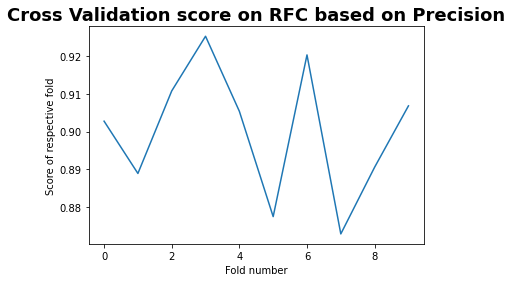


Mean Cross Validation scores based on Precision  is : 0.9000990132455439



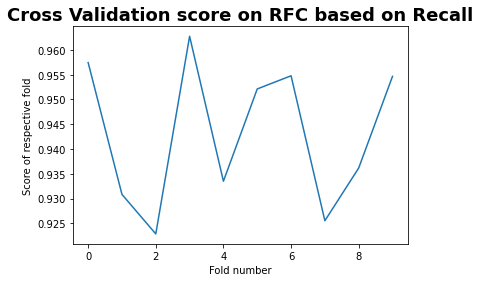


Mean Cross Validation scores based on Recall  is : 0.9430730496453898



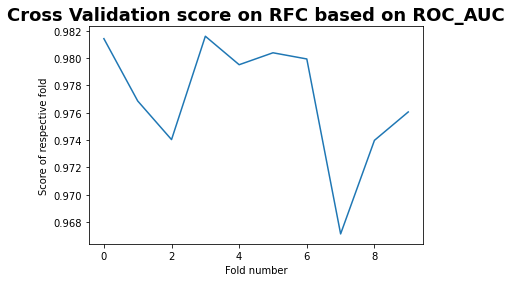


Mean Cross Validation scores based on ROC_AUC  is : 0.9770977525652633



In [64]:
cross_validation_plotting("RFC",cv_scores_precision_rfc,folds,"Precision")
cross_validation_plotting("RFC",cv_scores_recall_rfc,folds,"Recall")
cross_validation_plotting("RFC",cv_scores_roc_auc_rfc,folds,"ROC_AUC")

###KNN

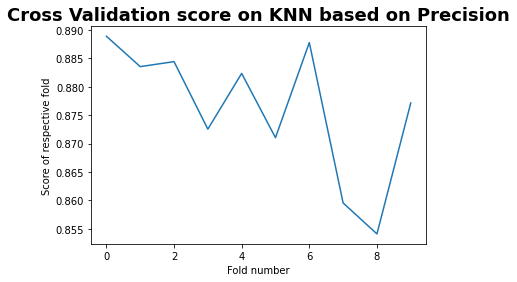


Mean Cross Validation scores based on Precision  is : 0.8761415730219937



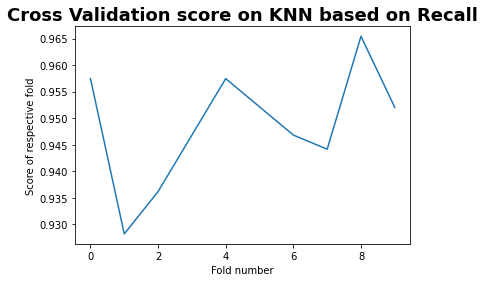


Mean Cross Validation scores based on Recall  is : 0.9486574468085106



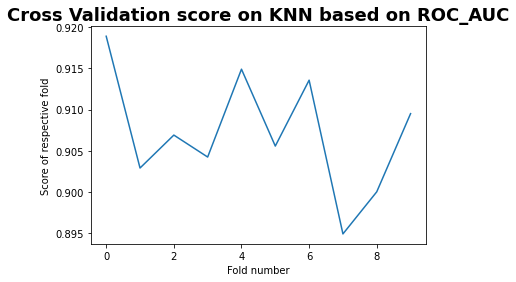


Mean Cross Validation scores based on ROC_AUC  is : 0.9071524822695036



In [65]:
cross_validation_plotting("KNN",cv_scores_precision_knn,folds,"Precision")
cross_validation_plotting("KNN",cv_scores_recall_knn,folds,"Recall")
cross_validation_plotting("KNN",cv_scores_roc_auc_knn,folds,"ROC_AUC")

###DTC

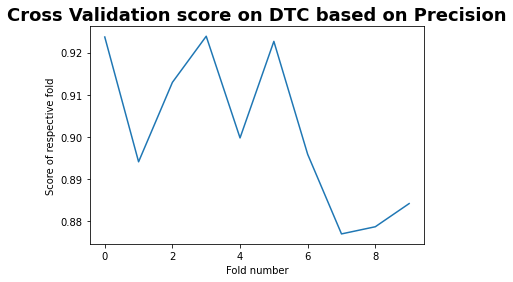


Mean Cross Validation scores based on Precision  is : 0.9012486868864757



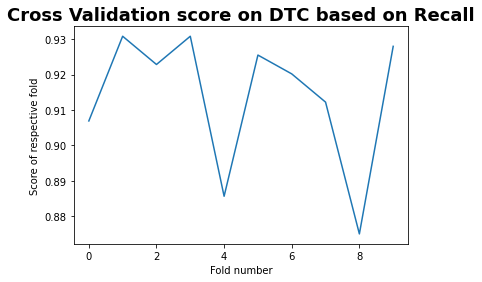


Mean Cross Validation scores based on Recall  is : 0.9138106382978725



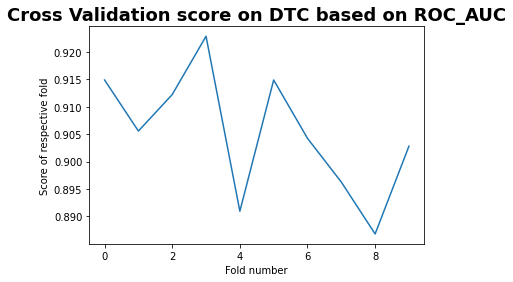


Mean Cross Validation scores based on ROC_AUC  is : 0.9051606382978722



In [66]:
cross_validation_plotting("DTC",cv_scores_precision_dtc,folds,"Precision")
cross_validation_plotting("DTC",cv_scores_recall_dtc,folds,"Recall")
cross_validation_plotting("DTC",cv_scores_roc_auc_dtc,folds,"ROC_AUC")

###GBC

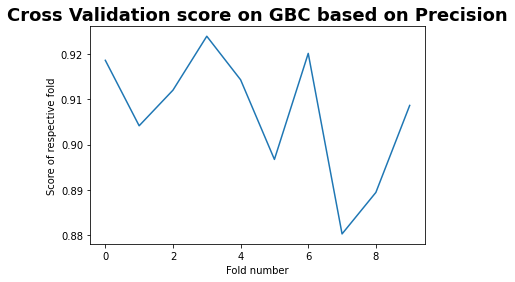


Mean Cross Validation scores based on Precision  is : 0.9068094833319993



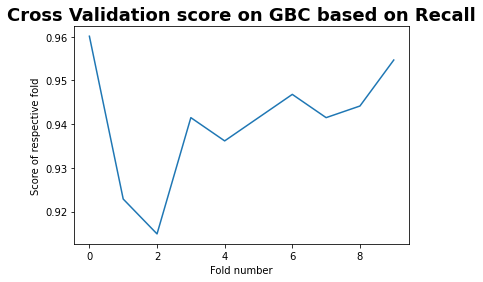


Mean Cross Validation scores based on Recall  is : 0.9404134751773048



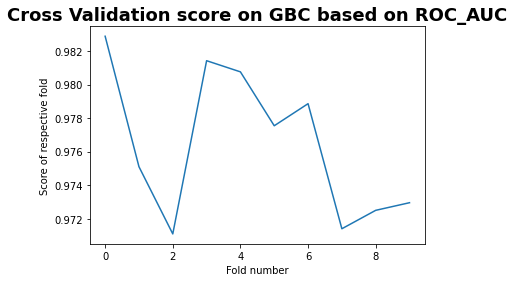


Mean Cross Validation scores based on ROC_AUC  is : 0.9764514439037273



In [67]:
cross_validation_plotting("GBC",cv_scores_precision_gbc,folds,"Precision")
cross_validation_plotting("GBC",cv_scores_recall_gbc,folds,"Recall")
cross_validation_plotting("GBC",cv_scores_roc_auc_gbc,folds,"ROC_AUC")

###Selecting on the basis of ROC AUC Score

In [68]:
cv_auc_roc_scores = []
cv_auc_roc_scores.append(sum(cv_scores_roc_auc_rfc)/ len(cv_scores_roc_auc_rfc))
cv_auc_roc_scores.append(sum(cv_scores_roc_auc_knn)/ len(cv_scores_roc_auc_knn))
cv_auc_roc_scores.append(sum(cv_scores_roc_auc_dtc)/ len(cv_scores_roc_auc_dtc))
cv_auc_roc_scores.append(sum(cv_scores_roc_auc_gbc)/ len(cv_scores_roc_auc_gbc))
cv_auc_roc_scores.append(cv_score_xgb)
cv_auc_roc_scores.append(cv_score_lgbm)

model_names = ['RandomForestClassifier', 'KNeighborsClassifier','DecisionTreeClassifier','GradientBoostingClassifier','XGBClassifier','LightGBM']
score = pd.DataFrame({'Model': model_names, 'Cross Validation AUC ROC Score':cv_auc_roc_scores})
score.style.background_gradient(high=1,axis=0)

,Model,Cross Validation AUC ROC Score
0,RandomForestClassifier,0.977098
1,KNeighborsClassifier,0.907152
2,DecisionTreeClassifier,0.905161
3,GradientBoostingClassifier,0.976451
4,XGBClassifier,0.961702
5,LightGBM,0.950000


So from above models we finally take RFC, GBC as classifier apart from xgb and lgbm

#Training a neural netwrok 

In [69]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [70]:
def get_accuracy(logit, target, batch_size):    # To calculate accuracy of neural network 
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [71]:
x_train_nn=x_train.values                      # To convert x_train and y_train into numpy array
y_train_nn=y_train.values

Defining Neural Network parameters

In [72]:
batch_size = 100                              
num_epochs = 100
learning_rate = 0.1
size_hidden_1 = 200
size_hidden_2 = 200
num_classes = 10
batch_no = len(x_train_nn) // batch_size 
cols = 8

Making neural network class

In [73]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, size_hidden_1, size_hidden_2, n_output, activation_function):    # num_inputs = number of features
        super(Net, self).__init__()                                   

        self.flatten1                     = torch.nn.Flatten()                                      # to flatten our input(multiple dimensional) into a tensor 
        
        self.dense1                       = torch.nn.Linear(num_inputs,size_hidden_1)               # hidden layer 
        self.activi1                      = activation_function                                     # user given activation function to be used in hidden layer 
        self.balancenormal1               = torch.nn.BatchNorm1d(size_hidden_1)                     # it normalizes the output of the hidden layer for activation function that have unbounded output range
        
        self.dense2                       = torch.nn.Linear(size_hidden_1,size_hidden_1)
        self.activi2                      = activation_function
        self.balancenormal2               = torch.nn.BatchNorm1d(size_hidden_1)
        
        self.dense3                       = torch.nn.Linear(size_hidden_1,size_hidden_1)
        self.activi3                      = activation_function
        self.balancenormal3               = torch.nn.BatchNorm1d(size_hidden_1)
        
        self.dense4                       = torch.nn.Linear(size_hidden_1,size_hidden_1)
        self.activi4                      = activation_function
        self.balancenormal4               = torch.nn.BatchNorm1d(size_hidden_1)

        self.dense5                       = torch.nn.Linear(size_hidden_1,size_hidden_1)
        self.activi5                      = activation_function
        self.balancenormal5               = torch.nn.BatchNorm1d(size_hidden_1)

        self.dense6                       = torch.nn.Linear(size_hidden_1,size_hidden_2)
        self.activi6                      = activation_function
        self.balancenormal6               = torch.nn.BatchNorm1d(size_hidden_2)

        self.dense7                      = torch.nn.Linear(size_hidden_2,size_hidden_2)
        self.activi7                      = activation_function
        self.balancenormal7               = torch.nn.BatchNorm1d(size_hidden_2)

        self.denseoutput                  = torch.nn.Linear(size_hidden_2,n_output)             # output layer 
        self.activipre                    = activation_function
        self.activioutput                 = torch.nn.Softmax(dim=1)                             # to convert the output from previous layer into probability for each class in the final output

    def forward(self, x):                                                                       # forward propogation 
        a= self.flatten1(x)                                                                     # 1 input flattening layer, 7 hidden layer and 1 output layer are used and are stacked on top of each other
        a= self.dense1(self.activi1(a))
        a= self.balancenormal1(a)
        a= self.dense2(self.activi2(a))
        a= self.balancenormal2(a)
        a= self.dense3(self.activi3(a))
        a= self.balancenormal3(a)
        a= self.dense4(self.activi4(a))
        a= self.balancenormal4(a)
        a= self.dense5(self.activi5(a))
        a= self.balancenormal5(a)
        a= self.dense6(self.activi6(a))
        a= self.balancenormal6(a)
        a= self.dense7(self.activi7(a))
        a= self.balancenormal7(a)
        a= self.denseoutput(self.activipre(a))
        a= self.activioutput(a)
        return(a)

activation_function=torch.nn.ReLU()
net = Net(9, 256, 256, 2, activation_function)

Training neural network

In [74]:
def train_neural_network(model,x,y,size_hidden_1,size_hidden_2,num_epochs,lr,batch_size):          # function to train neural network with given activation function,data,hidden layer size, number of epochs, learning rate, batch size
    batch_no=len(x.values)// batch_size
    x=x.values
    y=y.values
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)                              # to optimize weights in back propogation by stochastic gradient descent
    loss_func = torch.nn.CrossEntropyLoss()                                                        # to calculate loss on prediction
    for epoch in range(num_epochs):
        x, y = shuffle(x, y)                                                                       # shuffling our input while training 
        train_acc = 0.0
        running_loss = 0.0

        for i in range(batch_no):
            start = i * batch_size
            end = start + batch_size
            inputs = Variable(torch.FloatTensor(x[start:end]))                                     # converting  input into tensor matrix then converting into pytorch variable 
            labels = Variable(torch.LongTensor(y[start:end]))
            
            optimizer.zero_grad()                                                                  # setting optimizer to zero gradient to clear optimization of previous iteration if any
            outputs = model(inputs)                                                                # prediction on given input
            
            loss = loss_func(outputs, labels)                                                      # calculating loss
            
            loss.backward()                                                                        # performing backpropogation
            optimizer.step()
            running_loss += loss.item()
            acc = get_accuracy(outputs, labels, batch_size)                                        
            train_acc += acc
          
          # print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          #       %(epoch+1, running_loss / (i+1), train_acc/(i+1)))  
        running_loss = 0.0
    return(model)

In [75]:
train_neural_network(net,x_train,y_train['stroke'],size_hidden_1,size_hidden_2,num_epochs,learning_rate,batch_size)

Net(
  (flatten1): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=9, out_features=256, bias=True)
  (activi1): ReLU()
  (balancenormal1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense2): Linear(in_features=256, out_features=256, bias=True)
  (activi2): ReLU()
  (balancenormal2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense3): Linear(in_features=256, out_features=256, bias=True)
  (activi3): ReLU()
  (balancenormal3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense4): Linear(in_features=256, out_features=256, bias=True)
  (activi4): ReLU()
  (balancenormal4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense5): Linear(in_features=256, out_features=256, bias=True)
  (activi5): ReLU()
  (balancenormal5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense6): Linear(i

Testing neural network

In [76]:
def testing_nn(model,x,y,batch_size):
    x=x.values                                        # converting input into numpy array
    y=y['stroke'].values                              
    inputs=Variable(torch.FloatTensor(x))             # converting input from numpy array into pytorch variable
    labels=Variable(torch.FloatTensor(y))
    outputs= model(inputs)                            # perdiction
    return(get_accuracy(outputs, labels, batch_size)) # returning accuracy 

In [77]:
def prediction_nn(model,inputs,labels, batch_size):
    outputs=model(inputs)
    # return(outputs)
    return(get_accuracy(outputs,labels, batch_size))

In [78]:
x_nn_val=x_val.values
y_nn_val=y_val.values    # converting validation data into numpy array for validation

x_nn_test=x_test.values
y_nn_test=y_test.values

In [79]:
m=len(x_nn_val)
input_test= Variable(torch.FloatTensor(x_nn_val[0:m]))   # converting validation data into pytorch variable for validation
label_test= Variable(torch.LongTensor(y_nn_val[0:m]))

In [80]:
y_nn_pred=net(input_test)                                 # performing validation
validation_accuracy = get_accuracy(y_nn_pred, label_test, m)
validation_accuracy

87.1276626586914

Since the trained neural network is not as effective as the in built classifier hence we would be droppping the neural network for the final classification

#**Pipeline**
<img src="https://github.com/Shrut26/Stroke-Prediction/blob/main/Stroke%20Pipeline.png?raw=true" />

In [81]:
class Pipeline():
  def __init__(self,X,Y):
    smote = SMOTE()
    X_smote , Y_smote = smote.fit_resample(X,Y)
    x_train, y_train , x_val, y_val , x_test , y_test = self.split(X_smote,Y_smote)
    self.x_train = x_train
    self.y_train = y_train
    self.x_test  = x_test
    self.y_test  = y_test

  def split(self,X,Y): #to split the data
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3,random_state = 42)

    #to separate training data.
    for train_index, test_index in sss.split(X, Y):
      x_train = X.loc[train_index]
      y_train = Y.loc[train_index]
      test_x = X.loc[test_index]
      test_y = Y.loc[test_index]
    #to reset the index after splitting.
    x_train.reset_index(inplace = True)
    x_train.drop("index",axis = 1, inplace = True)

    y_train.reset_index(inplace = True)
    y_train.drop("index",axis = 1, inplace = True)

    test_x.reset_index(inplace = True)
    test_x.drop("index",axis = 1, inplace = True)

    test_y.reset_index(inplace = True)
    test_y.drop("index",axis = 1, inplace = True)

    sss = StratifiedShuffleSplit(n_splits=1, test_size= 1/3, random_state=42)
    #to split the remaining data into testing and val.
    for test_index, val_index in sss.split(test_x, test_y):
      x_test = test_x.loc[test_index]
      y_test = test_y.loc[test_index]
      x_val =   test_x.loc[val_index]
      y_val =   test_y.loc[val_index]


    x_test.reset_index(inplace = True)
    x_test.drop("index",axis = 1, inplace = True)

    y_test.reset_index(inplace = True)
    y_test.drop("index",axis = 1, inplace = True)

    x_val.reset_index(inplace = True)
    x_val.drop("index",axis = 1, inplace = True)

    y_val.reset_index(inplace = True)
    y_val.drop("index",axis = 1, inplace = True)

    return x_train, y_train , x_val, y_val , x_test , y_test
 
  # defining xgbclassification
  def xgbclassification(self):
    xgbclassifier = XGBClassifier(colsample_bytree = 0.7,gamma = 0.1,learning_rate =  0.1,max_depth = 8, min_child_weight = 3)
    xgbclassifier.fit(self.x_train, self.y_train)
    xgb_pred = xgbclassifier.predict(self.x_test)
    score = max(0,100*roc_auc_score(self.y_test, xgb_pred))
    print("Individual classifcation accuracy taking XGBClassifier is : " + str(score))
    return xgb_pred
  # defining lgbmclassification
  def lgbmclassification(self):
    lgbmclassifier = lgb.LGBMClassifier(colsample_bytree = 0.7,gamma = 0.1,learning_rate = 0.3,max_depth= 15,min_child_weight = 5)
    lgbmclassifier.fit(self.x_train, self.y_train)
    lgbm_pred = lgbmclassifier.predict(self.x_test)
    score = max(0,100*roc_auc_score(self.y_test, lgbm_pred))
    print("Individual classifcation accuracy taking LGBBClassifier is : " + str(score))
    return lgbm_pred

  # defining gbcclassification
  def gbcclassification(self):
    gbc = GradientBoostingClassifier(learning_rate=0.1,loss='exponential',max_depth=70,max_features=2,n_estimators=300)
    gbc.fit(self.x_train, self.y_train)
    gbc_pred = gbc.predict(self.x_test)
    score = max(0,100*roc_auc_score(self.y_test, gbc_pred))
    print("Individual classifcation accuracy taking Gradient Boosting Classifier is : " + str(score))
    return gbc_pred

  # defining rfcclassification
  def rfcclassification(self):
    rfc = RandomForestClassifier(bootstrap = False, max_depth = 24,max_features = 'sqrt',min_samples_leaf = 3, n_estimators = 265)
    # rfc = RandomForestClassifier(n_estimators=50,n_jobs=-1)
    rfc.fit(self.x_train, self.y_train)
    rfc_pred = rfc.predict(self.x_test)
    score = max(0,100*roc_auc_score(self.y_test, rfc_pred))
    print("Individual classifcation accuracy taking Random Forest Classifier is : " + str(score))
    return rfc_pred

#to final predict after combining all the models.
  def prediction(self,xgb_pred,lgbm_pred,gbc_pred,rfc_pred):
    final_prediction = []

    for iter in range(len(xgb_pred)):
      i = xgb_pred[iter]
      j = lgbm_pred[iter]
      k = gbc_pred[iter]
      l = rfc_pred[iter]


      zero = 0
      ones = 0

      if(i == 0):
        zero+=1
      elif(i==1):
        ones+=1

      if(j == 0):
        zero+=1
      elif(j==1):
        ones+=1

      if(k == 0):
        zero+=1
      elif(k==1):
        ones+=1

      if(l== 0):
        zero+=1
      elif(l==1):
        ones+=1

    
      if(zero > ones):
        final_prediction.append(0)
      
      if(ones > zero):
        final_prediction.append(1)

      if(zero == ones):
        if(i == 0):
          final_prediction.append(0)
        else:
          final_prediction.append(1)
      
    return final_prediction
  #to find the score of the final prediciton
  def Scoring(self,final_prediction):
    score = max(0,100*roc_auc_score(self.y_test, final_prediction))
    return score

In [82]:
pip = Pipeline(X,Y)
xgb_pred = pip.xgbclassification()
lgbm_pred = pip.lgbmclassification()
gbc_pred= pip.gbcclassification()
rfc_pred = pip.rfcclassification()
predictions = pip.prediction(xgb_pred,lgbm_pred,gbc_pred,rfc_pred)
score = pip.Scoring(predictions)
print("THE FINAL TESTING SCORE RECEIVED FOR THE GIVEN DATASET TAKING MAJORITY VOTING: " + str(score))

Individual classifcation accuracy taking XGBClassifier is : 95.15957446808511
Individual classifcation accuracy taking LGBBClassifier is : 95.31914893617022
Individual classifcation accuracy taking Gradient Boosting Classifier is : 93.40425531914894
Individual classifcation accuracy taking Random Forest Classifier is : 92.34042553191489
THE FINAL TESTING SCORE RECEIVED FOR THE GIVEN DATASET TAKING MAJORITY VOTING: 95.4787234042553


<p align = center>We can clearly see that Majority voting is performing better than using individual classifiers.</p>